<a href="https://colab.research.google.com/github/connectamn/AirQualityPrediction_UCI/blob/main/Predicting_Air_Quality_A_Machine_Learning_Approach_using_the_UCI_Air_Quality_Dataset(222_115_(173%2C190)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd                                                               # Import standard data science libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os                                                                         # Added for path manipulation

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV  # Import machine learning libraries and preprocessing tools
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from xgboost import XGBRegressor



import tensorflow as tf                                                           # Import libraries for building an Artificial Neural Network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Mount Google Drive

In [ ]:
# --- Mount Google Drive ---

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("\nGoogle Drive mounted successfully.")
except ImportError:
    print("Warning: `google.colab` not found. Skipping Google Drive mounting.")
    print("Please ensure your dataset is in the local directory if not using Colab.")

Mounted at /content/drive

Google Drive mounted successfully.


# Dataset Loading and EDA

In [ ]:
# --- Fetch Dataset from Google Drive ---

# This is the full path to your raw dataset file.
file_path = '/content/drive/MyDrive/AI/AirQualityUCI.csv'

output_dir = '/content/drive/MyDrive/AI'                                          # This is the directory where all output files will be saved. # New variable for output directory

try:
    df = pd.read_csv(file_path, sep=';')                                          # The dataset uses a semicolon as a separator
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please check the file path and ensure Google Drive is mounted correctly.")
    exit()

print("Initial Data Information:")
df.info()

Initial Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)


In [ ]:
# --- Data Preprocessing and Cleaning ---

df = df.iloc[:, :-2]                                                              # Drop the last two empty columns

cols_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']                         # Columns to convert from object to numeric, replacing commas with dots
for col in cols_to_convert:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')


df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')    # Convert 'Date' and 'Time' to a single datetime index
df = df.drop(columns=['Date', 'Time'])


df = df.replace(-200, np.nan)                                                     # Replace the missing value indicator (-200) with NaN

df = df.fillna(method='ffill')                                                    # Fill missing values using forward-fill, suitable for time-series data

df = df.dropna()                                                                  # Drop any remaining rows with NaN values

df = df.set_index('datetime')                                                     # Set datetime as the index

print("\nData Information after Preprocessing:")
df.info()



Data Information after Preprocessing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9471 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9471 non-null   float64
 1   PT08.S1(CO)    9471 non-null   float64
 2   NMHC(GT)       9471 non-null   float64
 3   C6H6(GT)       9471 non-null   float64
 4   PT08.S2(NMHC)  9471 non-null   float64
 5   NOx(GT)        9471 non-null   float64
 6   PT08.S3(NOx)   9471 non-null   float64
 7   NO2(GT)        9471 non-null   float64
 8   PT08.S4(NO2)   9471 non-null   float64
 9   PT08.S5(O3)    9471 non-null   float64
 10  T              9471 non-null   float64
 11  RH             9471 non-null   float64
 12  AH             9471 non-null   float64
dtypes: float64(13)
memory usage: 1.0 MB


/tmp/ipython-input-3353824607.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')                                                    # Fill missing values using forward-fill, suitable for time-series data


In [ ]:
# --- Exploratory Data Analysis (EDA) ---
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9471.000000  9471.000000  9471.000000  9471.000000    9471.000000   
mean      2.083613  1102.348432   270.550945    10.210970     943.805512   
std       1.460984   218.289826    72.865938     7.522406     268.195857   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.000000   940.000000   275.000000     4.400000     734.000000   
50%       1.700000  1065.000000   275.000000     8.400000     915.000000   
75%       2.700000  1235.000000   275.000000    13.900000    1113.500000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9471.000000   9471.000000  9471.000000   9471.000000  9471.000000   
mean    241.023334    830.590751   110.120051   1449.114455  1027.929891   
std     205.388102    254.912036    47.369418    347.139644   


--- Generating Scatter Plot with Categorical Coloring ---


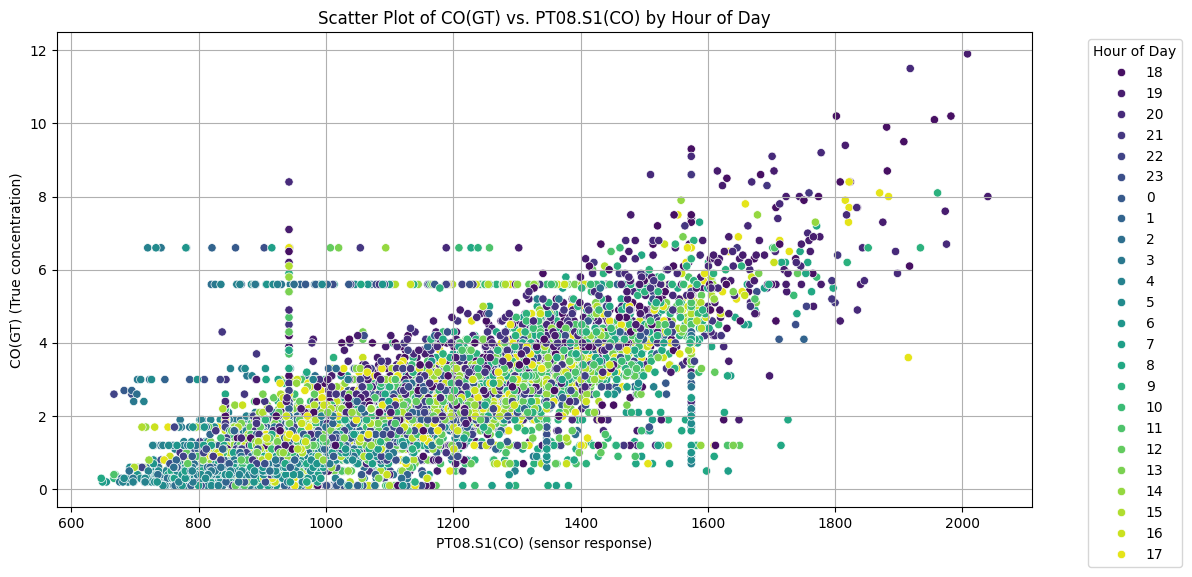

In [ ]:
# Create a categorical column based on the hour of the day
df['hour'] = df.index.hour.astype(str) # Convert hour to string to treat as categorical

# Create a scatter plot with color based on the new categorical 'hour' column
print("\n--- Generating Scatter Plot with Categorical Coloring ---")
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='PT08.S1(CO)', y='CO(GT)', hue='hour', palette='viridis', legend='full')
plt.title('Scatter Plot of CO(GT) vs. PT08.S1(CO) by Hour of Day')
plt.xlabel('PT08.S1(CO) (sensor response)')
plt.ylabel('CO(GT) (True concentration)')
plt.grid(True)
plt.legend(title='Hour of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() # Adjust layout to prevent legend overlapping
plt.show()


--- Generating Connected Scatterplot (CO(GT) over time) ---


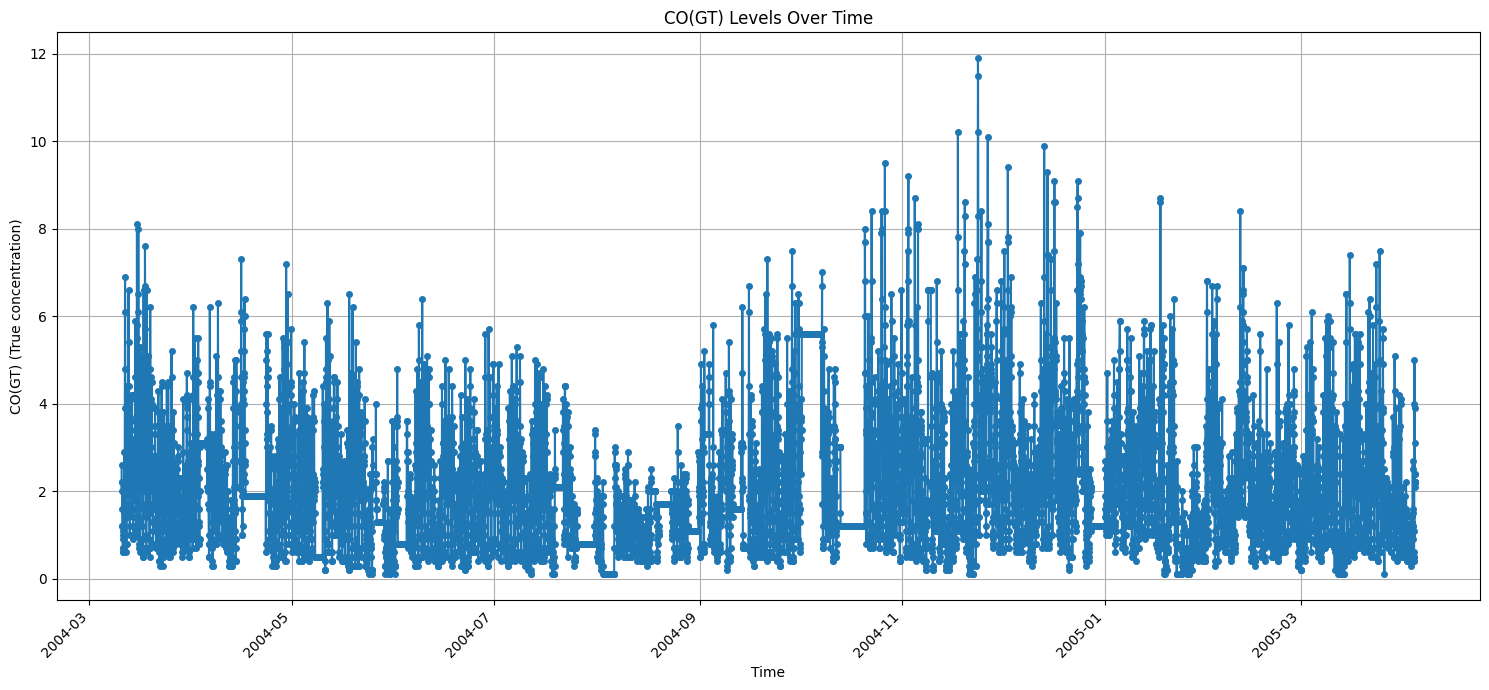


--- Generating Bubble Plot (CO(GT) vs. PT08.S1(CO) with Temperature as size) ---


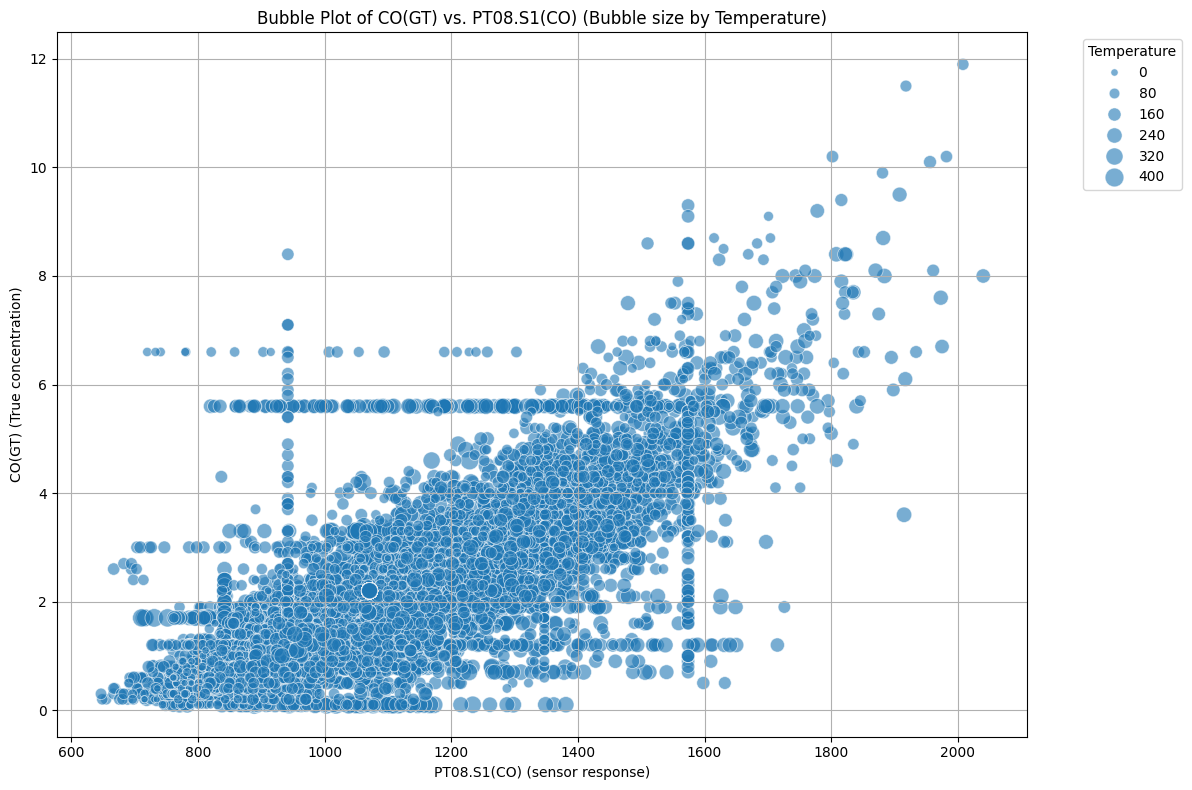

In [ ]:
# --- Connected Scatterplot (Example: CO(GT) over time) ---
# A connected scatterplot is good for visualizing trends over time.
print("\n--- Generating Connected Scatterplot (CO(GT) over time) ---")
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['CO(GT)'], marker='o', linestyle='-', markersize=4)
plt.title('CO(GT) Levels Over Time')
plt.xlabel('Time')
plt.ylabel('CO(GT) (True concentration)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# --- Bubble Plot (Example: CO(GT), PT08.S1(CO), and Temperature) ---
# Bubble plot can visualize three variables. Let's use CO(GT), PT08.S1(CO), and T (Temperature)
print("\n--- Generating Bubble Plot (CO(GT) vs. PT08.S1(CO) with Temperature as size) ---")
plt.figure(figsize=(12, 8))
# We'll use Temperature to determine the size of the bubbles
# Scale the temperature for better visualization if needed
size = df['T'] * 10 # Example scaling, adjust as necessary
sns.scatterplot(data=df, x='PT08.S1(CO)', y='CO(GT)', size=size, alpha=0.6, sizes=(20, 200))
plt.title('Bubble Plot of CO(GT) vs. PT08.S1(CO) (Bubble size by Temperature)')
plt.xlabel('PT08.S1(CO) (sensor response)')
plt.ylabel('CO(GT) (True concentration)')
plt.grid(True)
plt.legend(title='Temperature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



--- Generating Horizontal Bar Graph of Average Values ---


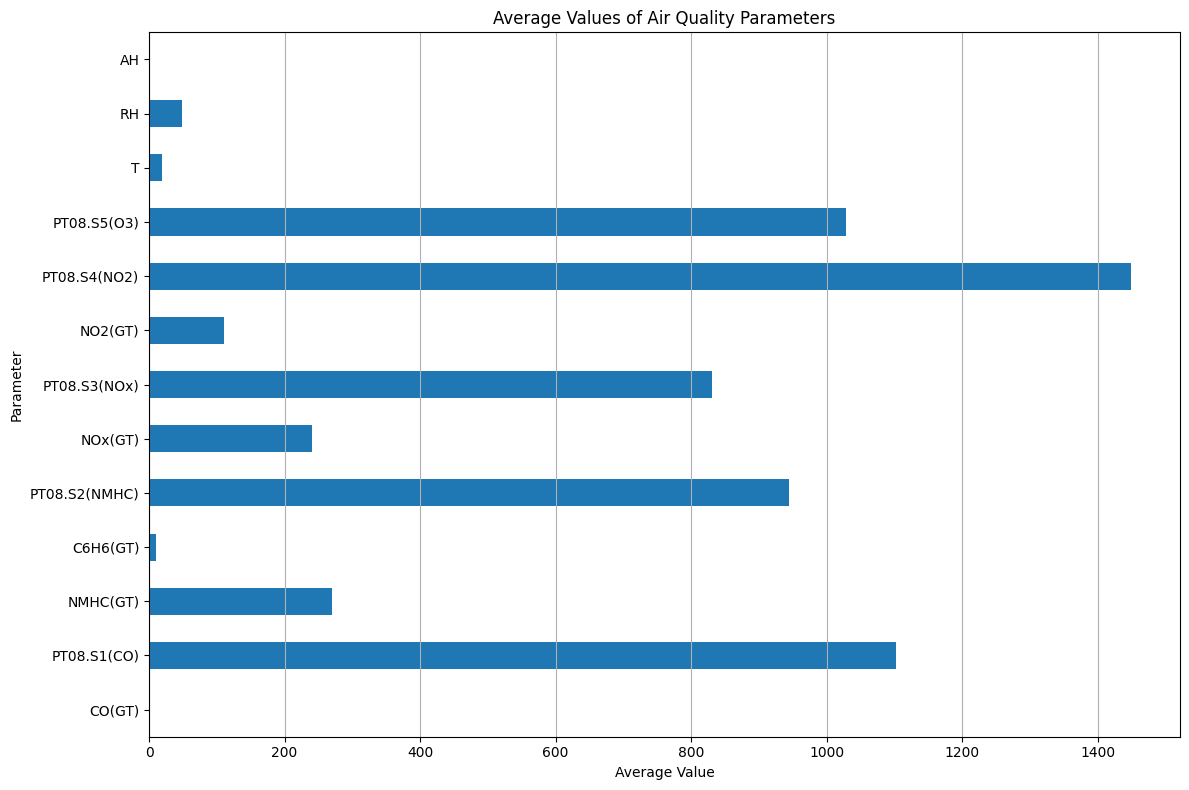

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Define the path to the preprocessed data
output_dir = '/content/drive/MyDrive/AI'
input_path = os.path.join(output_dir, 'air_quality_preprocessed.csv')

# Load the preprocessed data
try:
    df = pd.read_csv(input_path, index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print(f"Error: The file '{input_path}' was not found.")
    print("Please run the data preprocessing steps to generate the file.")
    exit()

# Calculate the average values of the numerical columns
average_values = df.mean()

# --- Generate Horizontal Bar Graph of Average Values ---
print("\n--- Generating Horizontal Bar Graph of Average Values ---")

plt.figure(figsize=(12, 8))
average_values.plot(kind='barh', ax=plt.gca()) # Use kind='barh' for horizontal bars and ax=plt.gca()
plt.title('Average Values of Air Quality Parameters')
plt.xlabel('Average Value')
plt.ylabel('Parameter')
plt.grid(axis='x') # Add vertical grid lines for horizontal bar graph
plt.tight_layout()
plt.show()


--- Generating Line Chart (Multiple parameters over time) ---


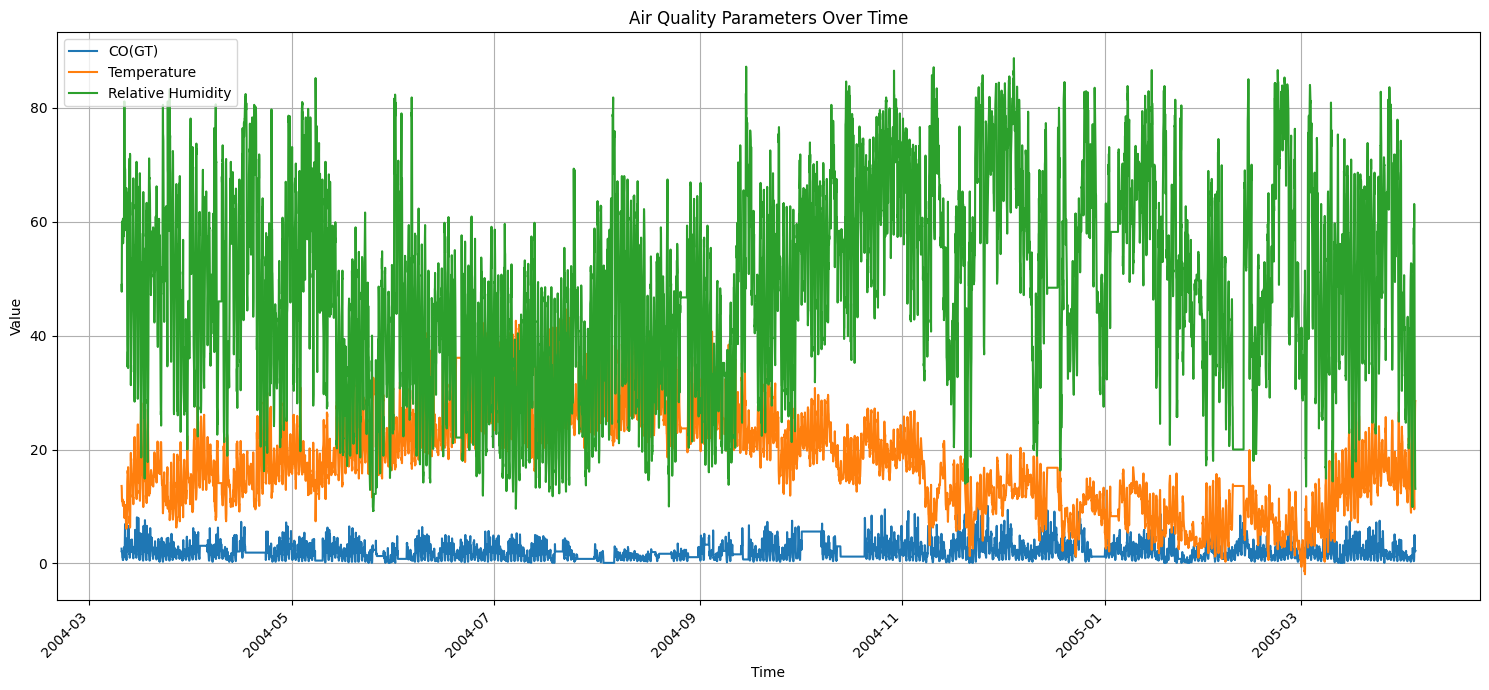


--- Generating Area Chart (CO(GT) over time) ---


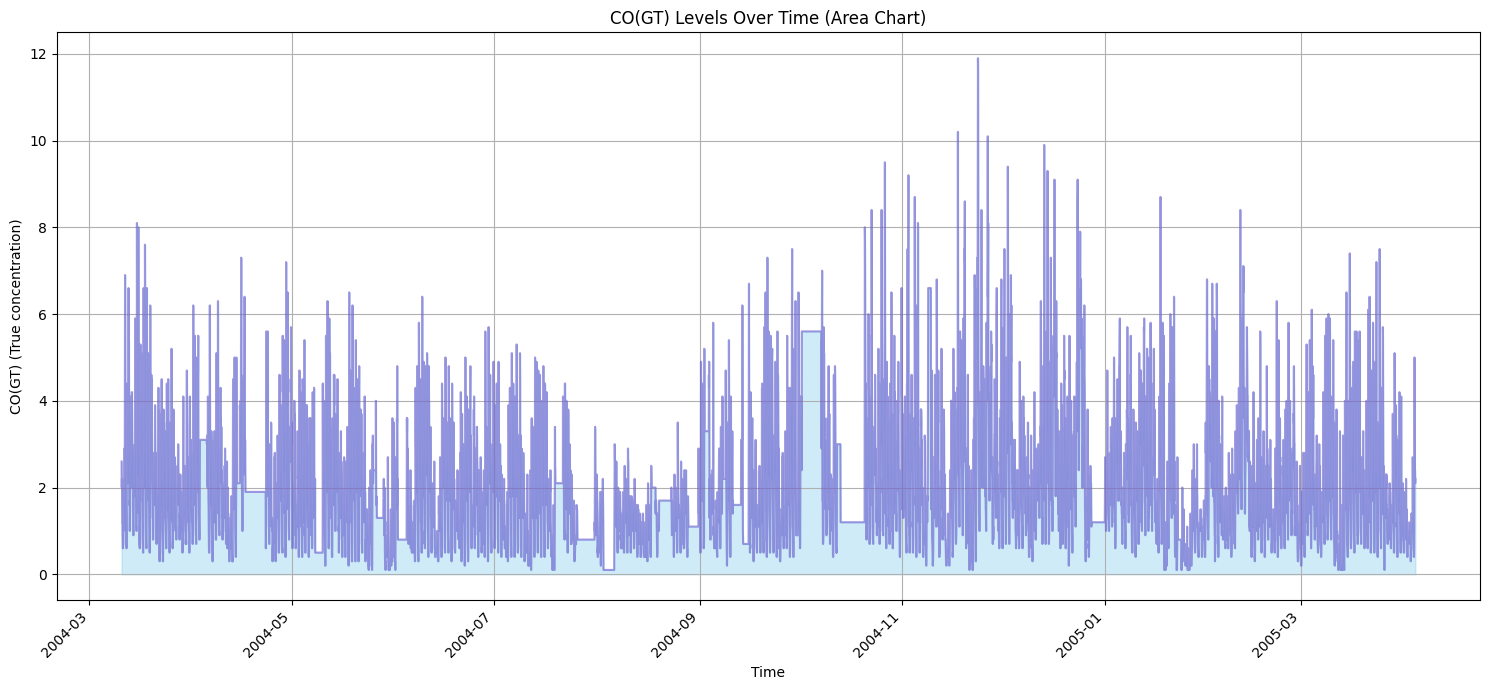

In [ ]:
# --- Line Chart (Example: Multiple parameters over time) ---
print("\n--- Generating Line Chart (Multiple parameters over time) ---")
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['CO(GT)'], label='CO(GT)')
plt.plot(df.index, df['T'], label='Temperature')
plt.plot(df.index, df['RH'], label='Relative Humidity')
plt.title('Air Quality Parameters Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Area Chart (Example: CO(GT) over time) ---
# Area charts can highlight the magnitude of a single variable over time.
print("\n--- Generating Area Chart (CO(GT) over time) ---")
plt.figure(figsize=(15, 7))
plt.fill_between(df.index, df['CO(GT)'], color="skyblue", alpha=0.4)
plt.plot(df.index, df['CO(GT)'], color="Slateblue", alpha=0.6)
plt.title('CO(GT) Levels Over Time (Area Chart)')
plt.xlabel('Time')
plt.ylabel('CO(GT) (True concentration)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

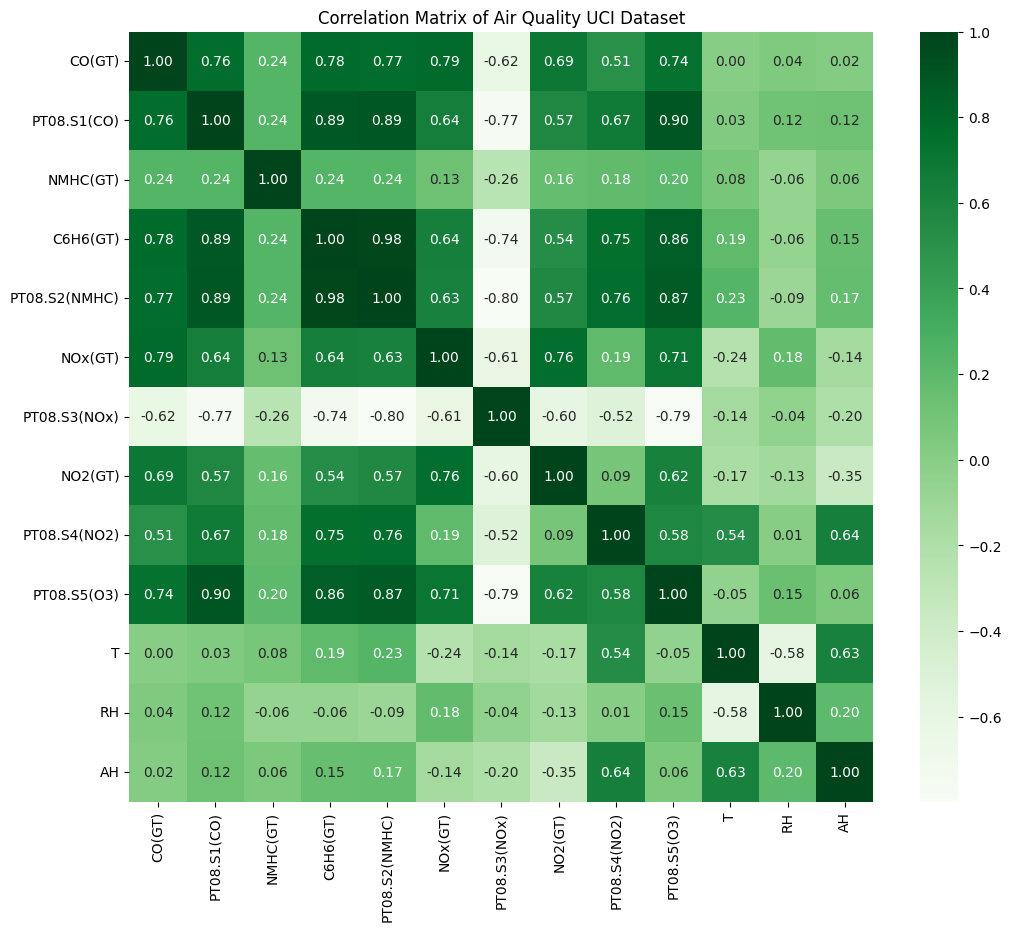

In [ ]:
# Generate a correlation matrix and a heatmap
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation Matrix of Air Quality UCI Dataset')
plt.show()

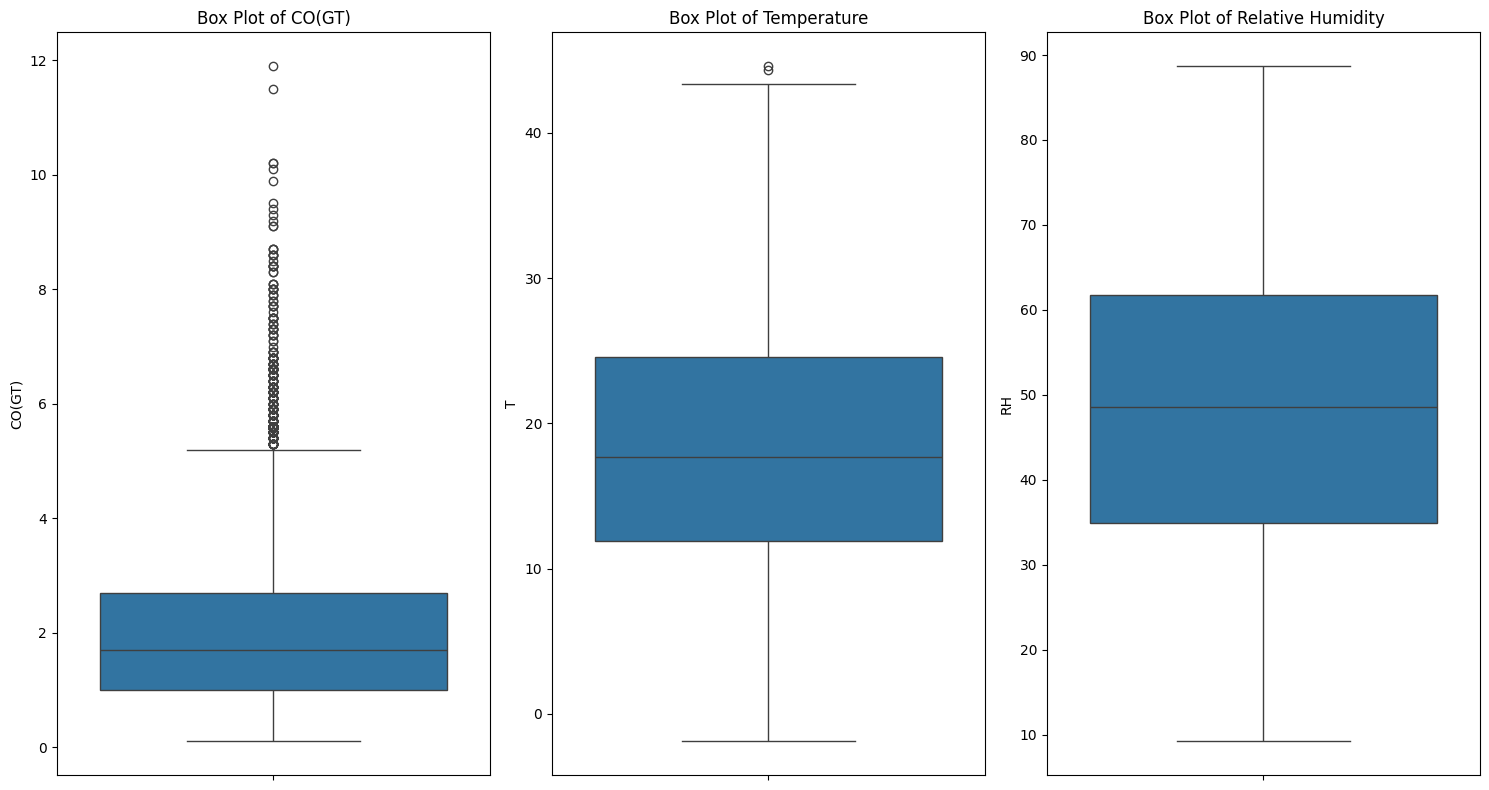

In [ ]:
# Visualize outliers with box plots for key features
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['CO(GT)'])
plt.title('Box Plot of CO(GT)')
plt.subplot(1, 3, 2)
sns.boxplot(y=df['T'])
plt.title('Box Plot of Temperature')
plt.subplot(1, 3, 3)
sns.boxplot(y=df['RH'])
plt.title('Box Plot of Relative Humidity')
plt.tight_layout()
plt.show()

In [ ]:
# Save the preprocessed DataFrame to Google Drive
output_path = os.path.join(output_dir, 'air_quality_preprocessed.csv') # Use output_dir
df.to_csv(output_path)
print(f"\nPreprocessed data saved to '{output_path}'")


Preprocessed data saved to '/content/drive/MyDrive/AI/air_quality_preprocessed.csv'


# Data Scaling for Outlier Handling

In [ ]:
output_dir = '/content/drive/MyDrive/AI'

# Paths for input and output files
input_path = os.path.join(output_dir, 'air_quality_preprocessed.csv')
scaled_features_path = os.path.join(output_dir, 'scaled_features.csv')
target_variable_path = os.path.join(output_dir, 'target_variable.csv')

# Load the preprocessed data from Google Drive
try:
    df = pd.read_csv(input_path, index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print(f"Error: The file '{input_path}' was not found.")
    print("Please run the previous code block to generate the file in your Google Drive.")
    exit()

print("Data loaded for scaling:")
df.info()

# Separate features (X) and the target variable (y)
X = df.drop(columns=['CO(GT)'])
y = df['CO(GT)']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features. This scales the data, handling outliers without removal.
X_scaled = scaler.fit_transform(X)

# Convert the scaled NumPy array back to a DataFrame for saving
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Save the scaled features and the target variable to the specified paths in Google Drive
X_scaled_df.to_csv(scaled_features_path)
y.to_csv(target_variable_path)

print(f"\nScaled features saved to '{scaled_features_path}'")
print(f"Target variable saved to '{target_variable_path}'")

Data loaded for scaling:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9471 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9471 non-null   float64
 1   PT08.S1(CO)    9471 non-null   float64
 2   NMHC(GT)       9471 non-null   float64
 3   C6H6(GT)       9471 non-null   float64
 4   PT08.S2(NMHC)  9471 non-null   float64
 5   NOx(GT)        9471 non-null   float64
 6   PT08.S3(NOx)   9471 non-null   float64
 7   NO2(GT)        9471 non-null   float64
 8   PT08.S4(NO2)   9471 non-null   float64
 9   PT08.S5(O3)    9471 non-null   float64
 10  T              9471 non-null   float64
 11  RH             9471 non-null   float64
 12  AH             9471 non-null   float64
dtypes: float64(13)
memory usage: 1.0 MB

Scaled features saved to '/content/drive/MyDrive/AI/scaled_features.csv'
Target variable saved to '/content/drive/MyDrive/AI/targe

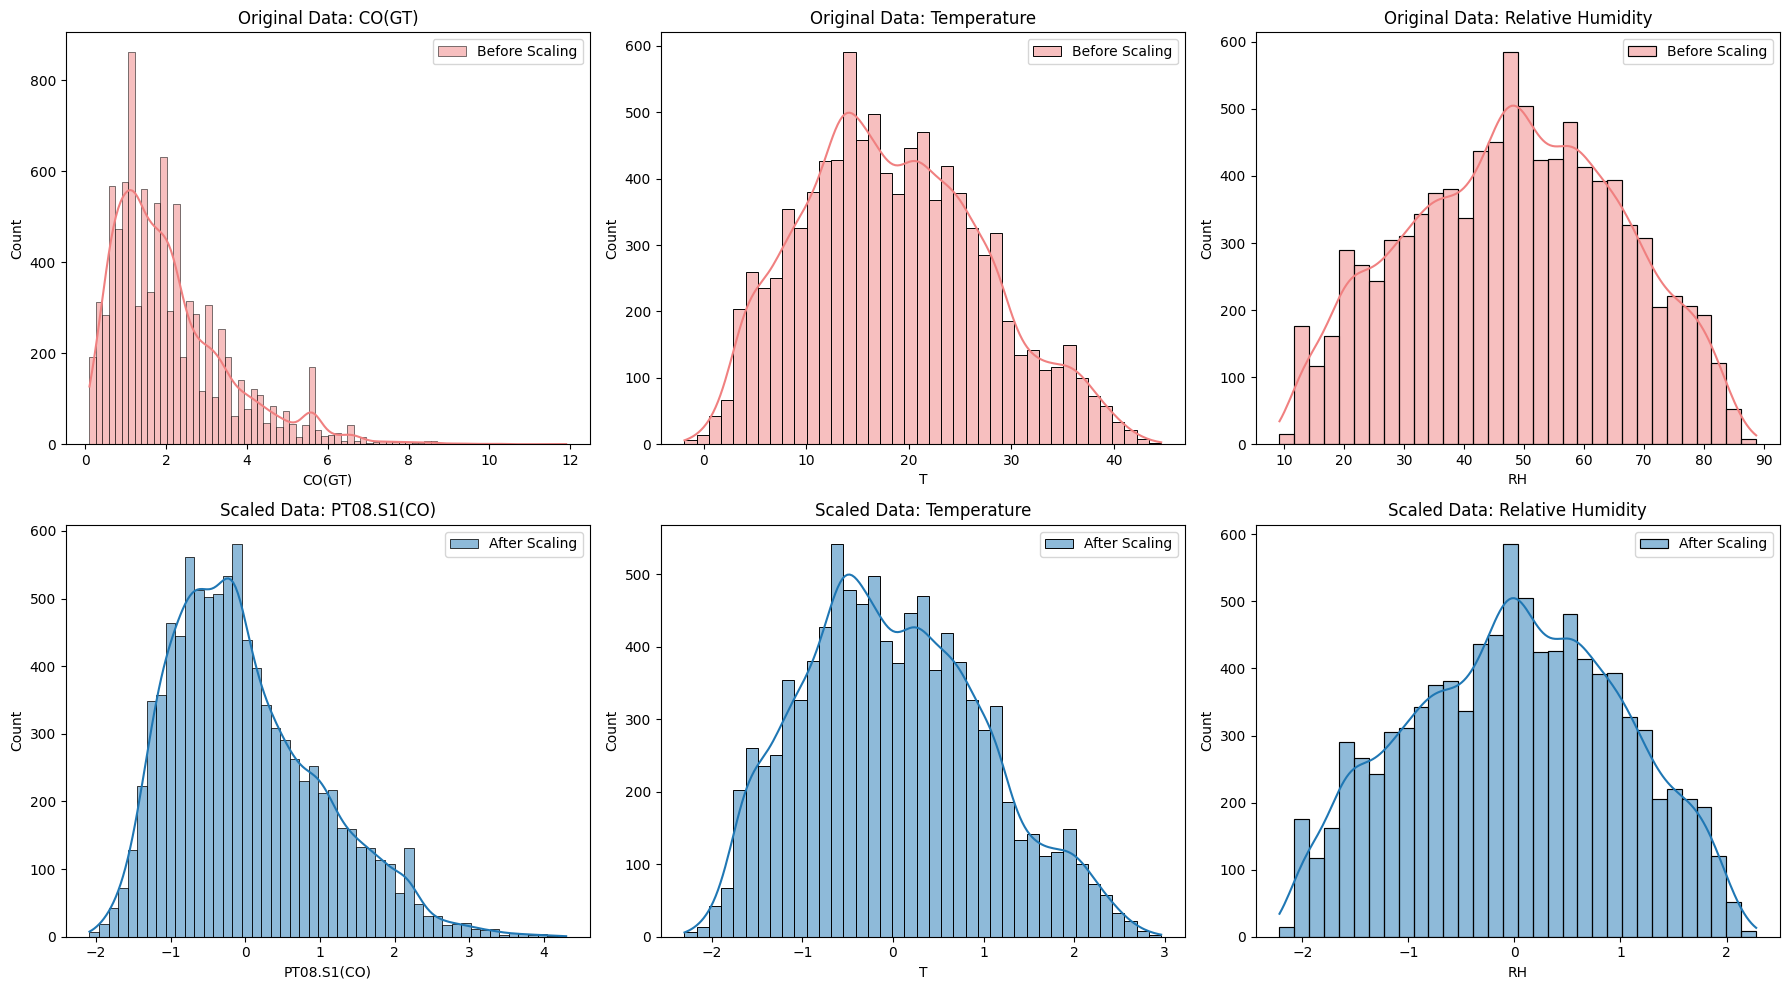

In [ ]:
# Visualize data distribution before and after scaling with histograms for key features
plt.figure(figsize=(18, 10))

# Histograms for original data
plt.subplot(2, 3, 1)
sns.histplot(df['CO(GT)'], kde=True, color='lightcoral', label='Before Scaling')
plt.title('Original Data: CO(GT)')
plt.legend()

plt.subplot(2, 3, 2)
sns.histplot(df['T'], kde=True, color='lightcoral', label='Before Scaling')
plt.title('Original Data: Temperature')
plt.legend()

plt.subplot(2, 3, 3)
sns.histplot(df['RH'], kde=True, color='lightcoral', label='Before Scaling')
plt.title('Original Data: Relative Humidity')
plt.legend()

# Histograms for scaled data
plt.subplot(2, 3, 4)
sns.histplot(X_scaled_df['PT08.S1(CO)'], kde=True, label='After Scaling')
plt.title('Scaled Data: PT08.S1(CO)')
plt.legend()

plt.subplot(2, 3, 5)
sns.histplot(X_scaled_df['T'], kde=True, label='After Scaling')
plt.title('Scaled Data: Temperature')
plt.legend()

plt.subplot(2, 3, 6)
sns.histplot(X_scaled_df['RH'], kde=True, label='After Scaling')
plt.title('Scaled Data: Relative Humidity')
plt.legend()

plt.tight_layout()
plt.show()


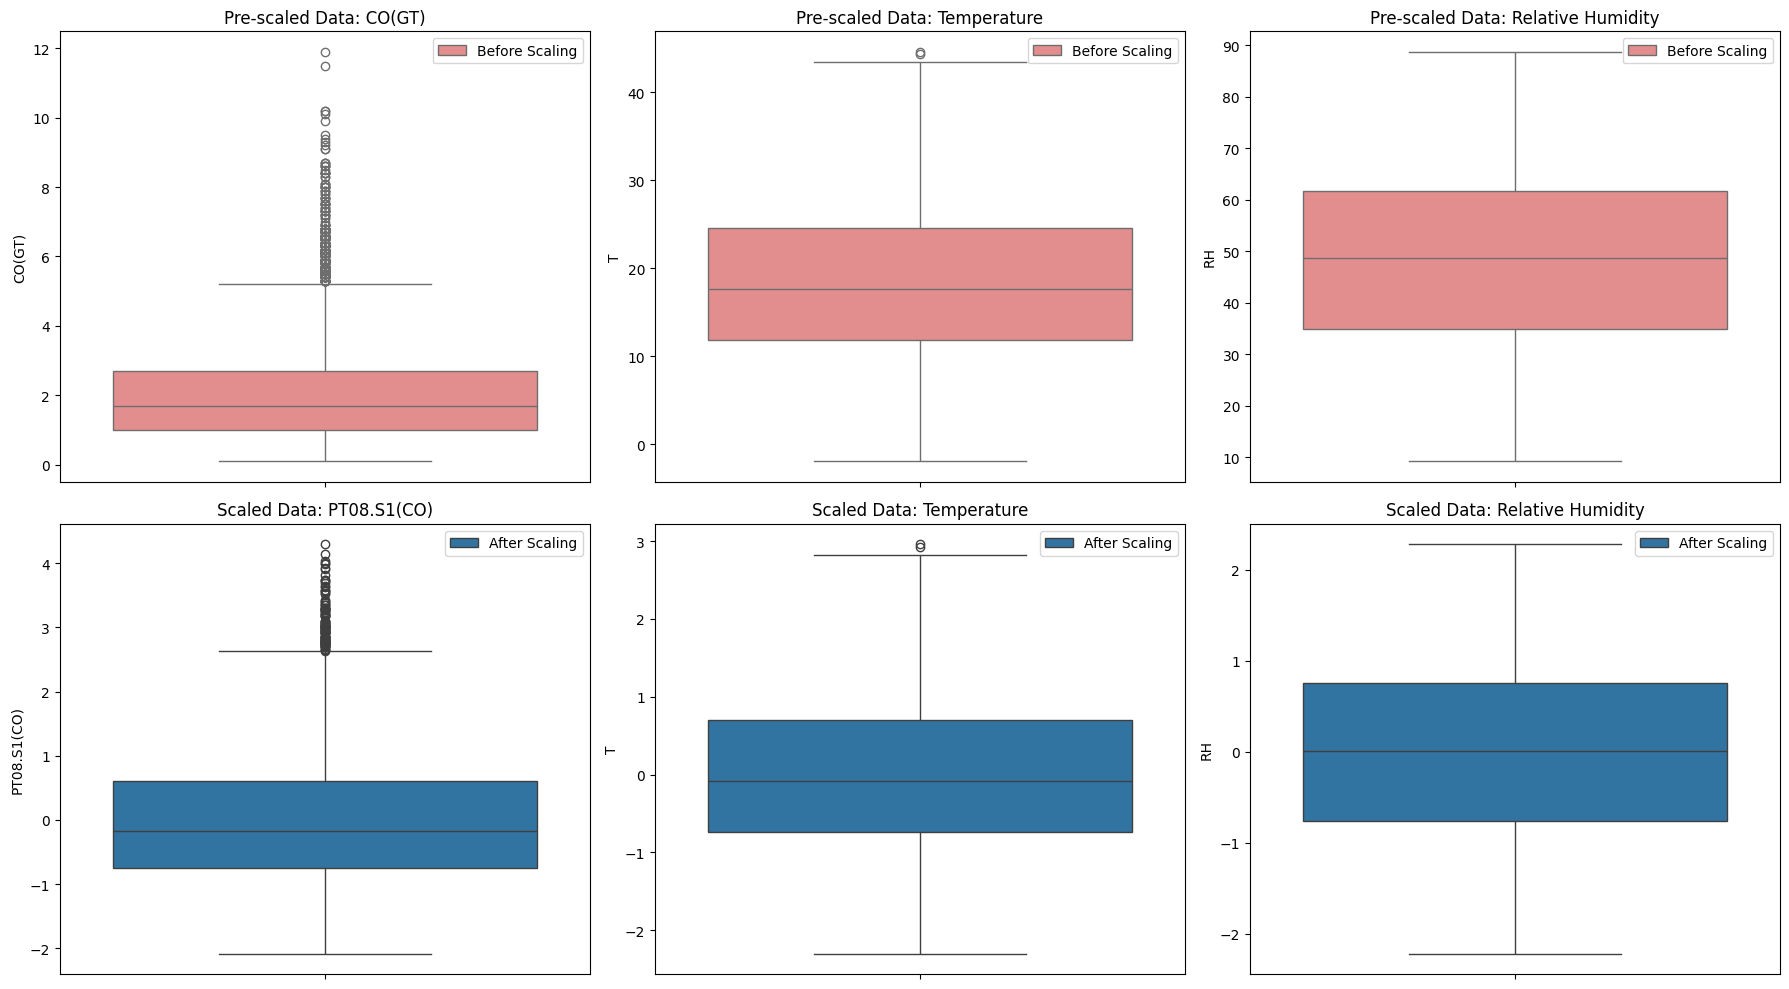

In [ ]:
# Visualize data distribution before and after scaling with box plots for key features
plt.figure(figsize=(18, 10))

# Box plots for pre-scaled data
plt.subplot(2, 3, 1)
sns.boxplot(y=df['CO(GT)'], color='lightcoral', label='Before Scaling')
plt.title('Pre-scaled Data: CO(GT)')
plt.legend()

plt.subplot(2, 3, 2)
sns.boxplot(y=df['T'], color='lightcoral', label='Before Scaling')
plt.title('Pre-scaled Data: Temperature')
plt.legend()

plt.subplot(2, 3, 3)
sns.boxplot(y=df['RH'], color='lightcoral', label='Before Scaling')
plt.title('Pre-scaled Data: Relative Humidity')
plt.legend

# Box plots for scaled data
plt.subplot(2, 3, 4)
sns.boxplot(y=X_scaled_df['PT08.S1(CO)'], label='After Scaling')  # Using a scaled feature as CO(GT) was removed before scaling
plt.title('Scaled Data: PT08.S1(CO)')

plt.subplot(2, 3, 5)
sns.boxplot(y=X_scaled_df['T'], label='After Scaling')
plt.title('Scaled Data: Temperature')

plt.subplot(2, 3, 6)
sns.boxplot(y=X_scaled_df['RH'], label='After Scaling')
plt.title('Scaled Data: Relative Humidity')

plt.tight_layout()
plt.show()



--- Generating Vertical Bar Graph of Average Values After Scaling ---


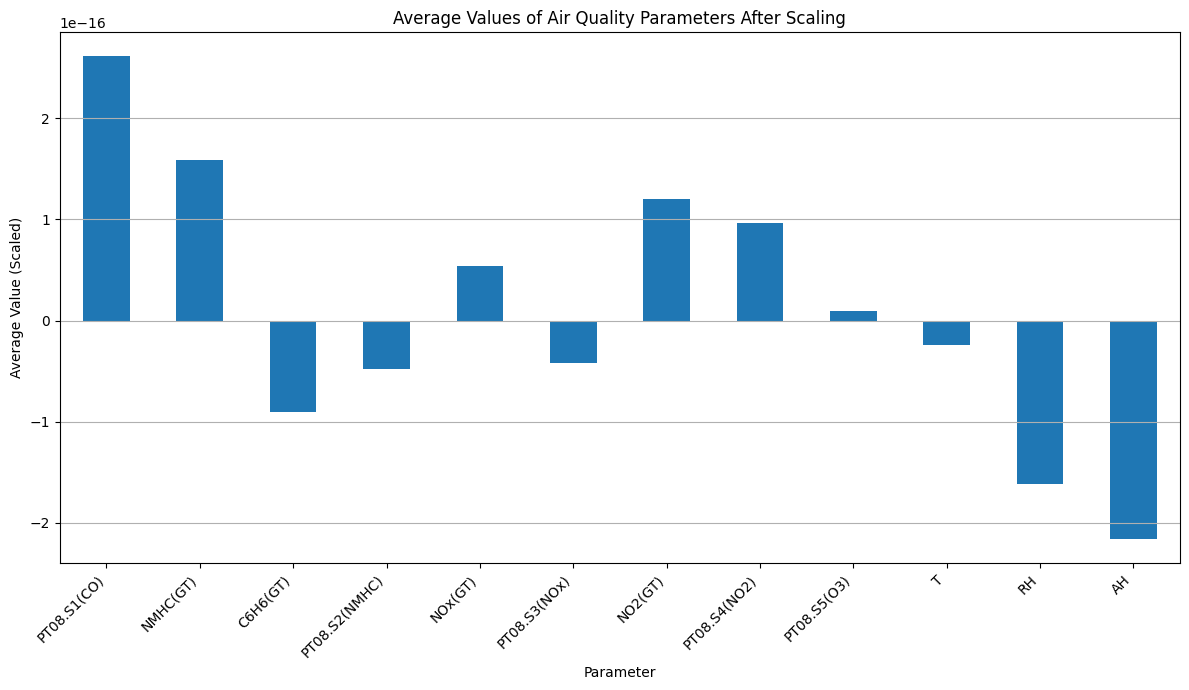

In [ ]:
# Define the path to the preprocessed data and scaled data
output_dir = '/content/drive/MyDrive/AI'
input_path = os.path.join(output_dir, 'air_quality_preprocessed.csv')
scaled_features_path = os.path.join(output_dir, 'scaled_features.csv')

# Load the preprocessed data (before scaling) - needed to get original column names if X_scaled_df doesn't retain them perfectly
try:
    df = pd.read_csv(input_path, index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print(f"Error: The file '{input_path}' was not found.")
    print("Please run the data preprocessing steps to generate the file.")
    exit()


# Load the scaled features (after scaling)
try:
    X_scaled_df = pd.read_csv(scaled_features_path, index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print(f"Error: The file '{scaled_features_path}' was not found.")
    print("Please run the data scaling steps to generate the file.")
    exit()


# Calculate the average values of the scaled numerical columns
# Exclude the 'hour' column if it was added to X_scaled_df
scaled_numerical_cols = X_scaled_df.select_dtypes(include=np.number).columns.tolist()
if 'hour' in scaled_numerical_cols:
    scaled_numerical_cols.remove('hour')

average_values_scaled = X_scaled_df[scaled_numerical_cols].mean()


# --- Generate Vertical Bar Graph of Average Values After Scaling ---
print("\n--- Generating Vertical Bar Graph of Average Values After Scaling ---")

plt.figure(figsize=(12, 7))
average_values_scaled.plot(kind='bar', ax=plt.gca())
plt.title('Average Values of Air Quality Parameters After Scaling')
plt.ylabel('Average Value (Scaled)')
plt.xlabel('Parameter')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.grid(axis='y') # Add horizontal grid lines
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


--- Generating Horizontal Bar Graph of Standard Deviations Before and After Scaling ---


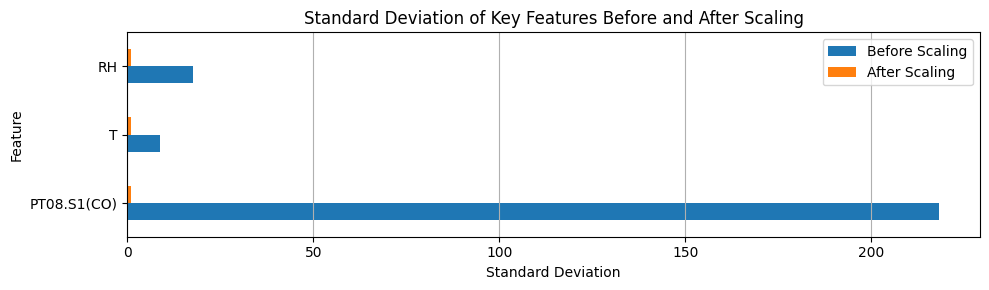

In [ ]:
# --- Visualize Standard Deviation Before and After Scaling with Horizontal Bar Graph ---
print("\n--- Generating Horizontal Bar Graph of Standard Deviations Before and After Scaling ---")

# Select key features for visualization (excluding the target variable CO(GT) from the original df)
key_features = ['PT08.S1(CO)', 'T', 'RH']

# Calculate standard deviation before and after scaling for key features
std_before_scaling = df[key_features].std()
std_after_scaling = X_scaled_df[key_features].std()

# Create a DataFrame for plotting
std_comparison_df = pd.DataFrame({
    'Before Scaling': std_before_scaling,
    'After Scaling': std_after_scaling
})

# Plotting the horizontal bar graph
plt.figure(figsize=(10, 3))
std_comparison_df.plot(kind='barh', ax=plt.gca()) # Use kind='barh' for horizontal bars and ax=plt.gca()
plt.title('Standard Deviation of Key Features Before and After Scaling')
plt.xlabel('Standard Deviation')
plt.ylabel('Feature')
plt.grid(axis='x') # Add vertical grid lines for horizontal bar graph
plt.tight_layout()
plt.show()


--- Visualizing Scatter Plots ---


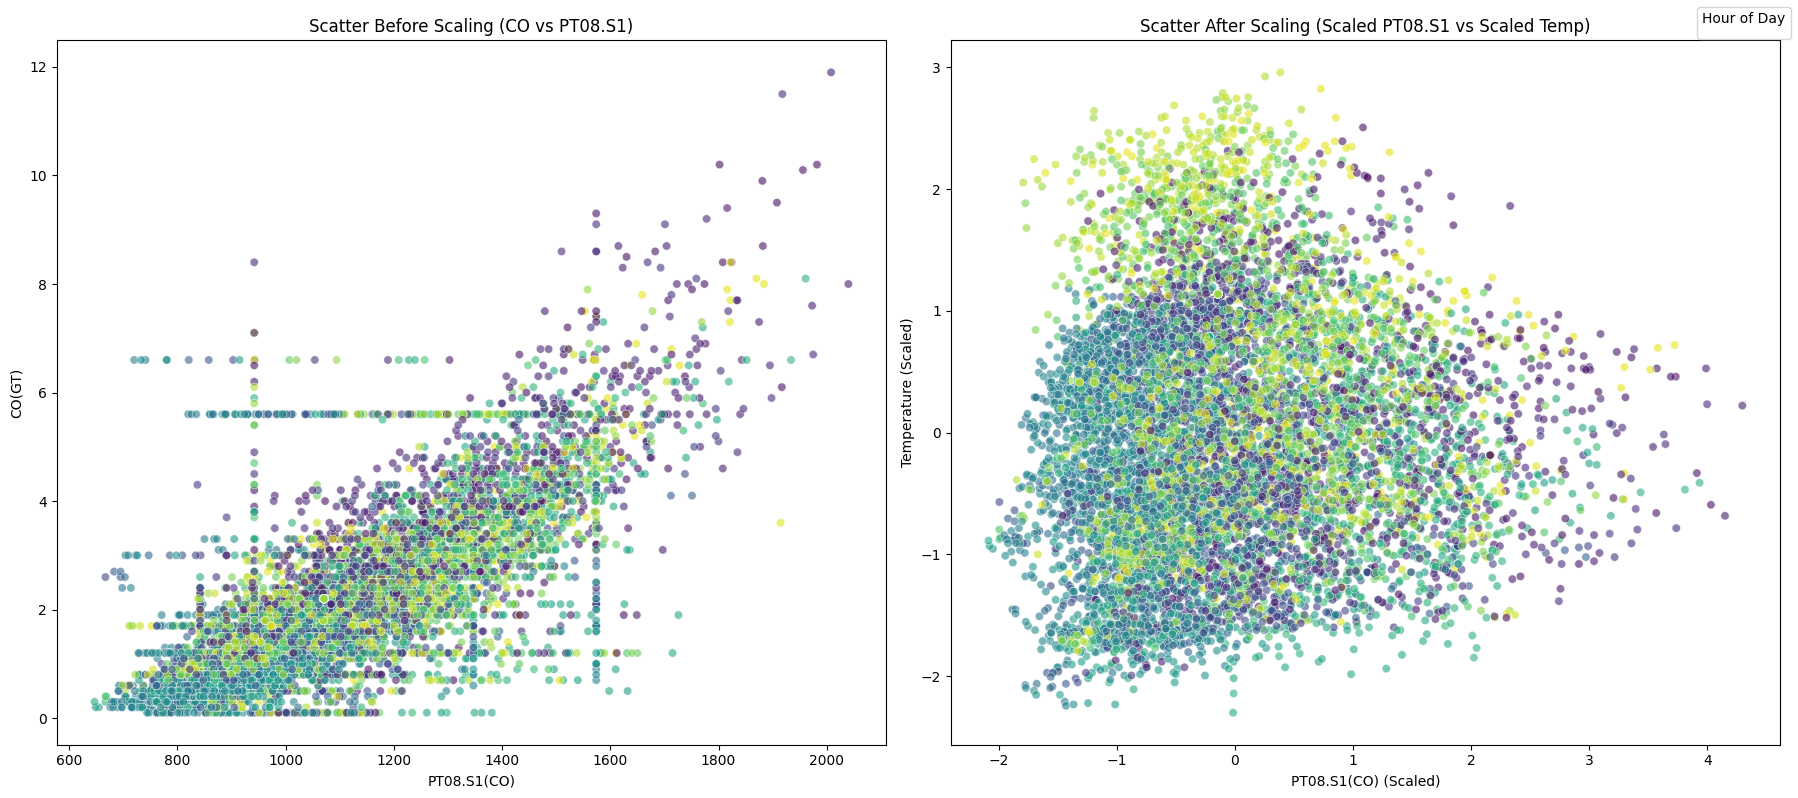

In [ ]:
# Define the path to the preprocessed data and scaled data
output_dir = '/content/drive/MyDrive/AI'
input_path = os.path.join(output_dir, 'air_quality_preprocessed.csv')
scaled_features_path = os.path.join(output_dir, 'scaled_features.csv')


# Load the preprocessed data (before scaling)
try:
    df = pd.read_csv(input_path, index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print(f"Error: The file '{input_path}' was not found.")
    print("Please run the data preprocessing steps to generate the file.")
    exit()

# Load the scaled features (after scaling)
try:
    X_scaled_df = pd.read_csv(scaled_features_path, index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print(f"Error: The file '{scaled_features_path}' was not found.")
    print("Please run the data scaling steps to generate the file.")
    exit()

# Create a categorical 'hour' column for both dataframes
df['hour'] = df.index.hour.astype(str)
X_scaled_df['hour'] = X_scaled_df.index.hour.astype(str) # Add hour column to scaled dataframe


# --- Separate Figure for Scatter Plots ---
print("\n--- Visualizing Scatter Plots ---")

fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Scatter Before Scaling
sns.scatterplot(data=df, x='PT08.S1(CO)', y='CO(GT)', hue='hour', palette='viridis', legend=False, alpha=0.6, ax=axes2[0])
axes2[0].set_title('Scatter Before Scaling (CO vs PT08.S1)')
axes2[0].set_xlabel('PT08.S1(CO)')
axes2[0].set_ylabel('CO(GT)')
handles, labels = axes2[0].get_legend_handles_labels()

# Scatter After Scaling
sns.scatterplot(data=X_scaled_df, x='PT08.S1(CO)', y='T', hue='hour', palette='viridis', legend=False, alpha=0.6, ax=axes2[1])
axes2[1].set_title('Scatter After Scaling (Scaled PT08.S1 vs Scaled Temp)')
axes2[1].set_xlabel('PT08.S1(CO) (Scaled)')
axes2[1].set_ylabel('Temperature (Scaled)')

# Add shared legend
fig2.legend(handles, labels, title='Hour of Day', loc='upper right')

plt.tight_layout()
plt.show()

### Explaining Scatter Plots Before and After Scaling

The scatter plots you generated (for example, in the combined EDA figure in cell `Jv2dWci69QAy`) visualize the relationship between two features before and after applying the `StandardScaler`. Here's a breakdown of what they show:

**Scatter Plot Before Scaling (e.g., CO(GT) vs. PT08.S1(CO))**

*   **What it shows:** This plot displays the raw, preprocessed data points for two selected features (e.g., the true CO concentration `CO(GT)` on the y-axis and the CO sensor response `PT08.S1(CO)` on the x-axis).
*   **Interpretation:** You can see the original range and spread of the data for each feature. The distribution of points reflects the inherent relationship between the two variables in their original scales. Outliers, if present, will appear as points far away from the main cluster of data, in the original units of measurement. The categorical coloring (by hour of the day) helps to see if this relationship varies at different times.

**Scatter Plot After Scaling (e.g., Scaled PT08.S1(CO) vs. Scaled Temperature)**

*   **What it shows:** This plot displays the same data points, but the values of the selected features have been transformed by the `StandardScaler`. The features are now centered around zero and have a standard deviation of one. (Note: In the combined EDA plot, we used Scaled PT08.S1(CO) vs. Scaled Temperature as an example of two scaled features).
*   **Interpretation:** Notice how the range of values on both the x and y axes has changed significantly compared to the 'before scaling' plot. The data points are now clustered around the origin (0,0). The relative positions of the points to each other remain the same, meaning the underlying relationship between the two features is preserved, but their absolute values and spread are normalized. Outliers are still present, but they are also scaled relative to the rest of the data. The categorical coloring by hour of the day will show the same time-based patterns, but within the new scaled coordinate system.

**Key Takeaway:**

Comparing these two scatter plots visually demonstrates the effect of `StandardScaler`. It shows that scaling compresses or expands the data range of features so they are on a similar scale, which is crucial for many machine learning algorithms. It also shows that scaling preserves the relationships between features and the relative positions of outliers, rather than removing them.

# Advanced ML Models and Cross-Validation

In [ ]:
output_dir = '/content/drive/MyDrive/AI'

# Load the scaled features and target variable from the previous step
try:
    X = pd.read_csv(os.path.join(output_dir, 'scaled_features.csv'), index_col='datetime', parse_dates=True)
    y_df = pd.read_csv(os.path.join(output_dir, 'target_variable.csv'), index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print("Error: Scaled feature or target variable files were not found.")
    print("Please run the previous code blocks to generate the files.")
    exit()

# Extract the Series from the DataFrame to avoid shape mismatches
y = y_df['CO(GT)']

print("Data loaded for model training:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data loaded for model training:
Features shape: (9471, 12)
Target shape: (9471,)


In [ ]:
# --- XGBoost Regressor ---
print("\n--- Running XGBoost Regressor ---")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost Mean Squared Error (MSE): {mse_xgb:.4f}")


--- Running XGBoost Regressor ---
XGBoost Mean Squared Error (MSE): 0.2387


In [ ]:
# --- Support Vector Machine (SVM) Regressor ---
print("\n--- Running SVM Regressor ---")
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train.values.ravel())
y_pred_svm = svm_model.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"SVM Mean Squared Error (MSE): {mse_svm:.4f}")


--- Running SVM Regressor ---
SVM Mean Squared Error (MSE): 0.2536


In [ ]:
# --- Cross-Validation and Hyperparameter Tuning for SVM ---
print("\n--- Cross-Validation and Grid Search for SVM ---")
# Define a parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y.values.ravel())

print(f"Best parameters found: {grid_search.best_params_}")
best_svm = grid_search.best_estimator_
best_svm_score = -grid_search.best_score_
print(f"Best SVM Cross-Validation MSE: {best_svm_score:.4f}")


--- Cross-Validation and Grid Search for SVM ---
Best parameters found: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVM Cross-Validation MSE: 0.6180


In [ ]:
# --- Artificial Neural Network (ANN) ---
print("\n--- Running Artificial Neural Network (ANN) ---")
# Define the model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# Use validation_split to monitor performance on a portion of the training data
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred_ann = ann_model.predict(X_test)
mse_ann = mean_squared_error(y_test, y_pred_ann)
print(f"ANN Mean Squared Error (MSE): {mse_ann:.4f}")


--- Running Artificial Neural Network (ANN) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ANN Mean Squared Error (MSE): 0.2667


In [ ]:
# --- Random Forest Regressor ---
print("\n--- Running Random Forest Regressor ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error (MSE): {mse_rf:.4f}")


--- Running Random Forest Regressor ---
Random Forest Mean Squared Error (MSE): 0.2601


In [ ]:
# Display a summary of all model performances
print("\n--- Final Model Performance Summary (MSE) ---")
print(f"XGBoost Regressor: {mse_xgb:.4f}")
print(f"SVM Regressor: {mse_svm:.4f}")
print(f"Best Cross-Validated SVM: {best_svm_score:.4f}")
print(f"ANN: {mse_ann:.4f}")
print(f"Random Forest Regressor: {mse_rf:.4f}")


--- Final Model Performance Summary (MSE) ---
XGBoost Regressor: 0.2387
SVM Regressor: 0.2536
Best Cross-Validated SVM: 0.6180
ANN: 0.2667
Random Forest Regressor: 0.2601


In [ ]:
# Compare the models and identify the best one
model_performances = {
    'XGBoost Regressor': mse_xgb,
    'SVM Regressor': mse_svm,
    'Best Cross-Validated SVM': best_svm_score,
    'ANN': mse_ann,
    'Random Forest Regressor': mse_rf
}

best_model = min(model_performances, key=model_performances.get)
lowest_mse = model_performances[best_model]

print(f"\nThe model with the lowest MSE is the {best_model} with an MSE of {lowest_mse:.4f}.")


The model with the lowest MSE is the XGBoost Regressor with an MSE of 0.2387.


In [ ]:
# --- Ensemble Regression (Averaging Predictions) ---
print("\n--- Running Ensemble Regression (Averaging) ---")

# Ensure all prediction arrays have the same shape
# This might be necessary if models output predictions in slightly different formats
# For simplicity, we'll assume they are compatible NumPy arrays or can be easily converted
# If not, you might need to reshape or broadcast them
y_pred_ensemble = (y_pred_xgb + y_pred_svm + y_pred_ann.flatten() + y_pred_rf) / 4.0

mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
print(f"Ensemble (Averaging) Mean Squared Error (MSE): {mse_ensemble:.4f}")

# Add ensemble performance to the summary
model_performances['Ensemble (Averaging)'] = mse_ensemble

print("\n--- Updated Model Performance Summary (MSE) ---")
for model, mse in model_performances.items():
    print(f"{model}: {mse:.4f}")

best_model_updated = min(model_performances, key=model_performances.get)
lowest_mse_updated = model_performances[best_model_updated]

print(f"\nThe model with the lowest MSE after adding the ensemble is the {best_model_updated} with an MSE of {lowest_mse_updated:.4f}.")


--- Running Ensemble Regression (Averaging) ---
Ensemble (Averaging) Mean Squared Error (MSE): 0.2295

--- Updated Model Performance Summary (MSE) ---
XGBoost Regressor: 0.2387
SVM Regressor: 0.2536
Best Cross-Validated SVM: 0.6180
ANN: 0.2667
Random Forest Regressor: 0.2601
Ensemble (Averaging): 0.2295

The model with the lowest MSE after adding the ensemble is the Ensemble (Averaging) with an MSE of 0.2295.


In [ ]:
# --- Hyperparameter Tuning for XGBoost Regressor ---
print("\n--- Hyperparameter Tuning for XGBoost Regressor ---")

# Define a parameter grid to search
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the grid search
grid_search_xgb.fit(X_train, y_train)

print(f"Best parameters found for XGBoost: {grid_search_xgb.best_params_}")

# Evaluate the best XGBoost model
best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
print(f"Best Tuned XGBoost Mean Squared Error (MSE): {mse_best_xgb:.4f}")

# Add the best tuned XGBoost performance to the summary
model_performances['Best Tuned XGBoost'] = mse_best_xgb

print("\n--- Updated Model Performance Summary (MSE) ---")
for model, mse in model_performances.items():
    print(f"{model}: {mse:.4f}")

best_model_updated = min(model_performances, key=model_performances.get)
lowest_mse_updated = model_performances[best_model_updated]

print(f"\nThe model with the lowest MSE after tuning XGBoost is the {best_model_updated} with an MSE of {lowest_mse_updated:.4f}.")


--- Hyperparameter Tuning for XGBoost Regressor ---
Best parameters found for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Best Tuned XGBoost Mean Squared Error (MSE): 0.2145

--- Updated Model Performance Summary (MSE) ---
XGBoost Regressor: 0.2387
SVM Regressor: 0.2536
Best Cross-Validated SVM: 0.6180
ANN: 0.2667
Random Forest Regressor: 0.2601
Ensemble (Averaging): 0.2295
Best Tuned XGBoost: 0.2145

The model with the lowest MSE after tuning XGBoost is the Best Tuned XGBoost with an MSE of 0.2145.


In [ ]:
# Calculate R-squared for each model
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_svm = r2_score(y_test, y_pred_svm)
r2_ann = r2_score(y_test, y_pred_ann)
r2_rf = r2_score(y_test, y_pred_rf)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
r2_ensemble = r2_score(y_test, y_pred_ensemble)


# Display a summary of all model performances (MSE and R-squared)
print("\n--- Final Model Performance Summary ---")
print(f"XGBoost Regressor:")
print(f"  MSE: {mse_xgb:.4f}")
print(f"  R-squared: {r2_xgb:.4f}")
print(f"SVM Regressor:")
print(f"  MSE: {mse_svm:.4f}")
print(f"  R-squared: {r2_svm:.4f}")
print(f"Best Cross-Validated SVM:")
print(f"  Cross-Validation MSE: {best_svm_score:.4f}")
# Note: R-squared for cross-validated SVM is not directly comparable to test set R-squared here.
print(f"ANN:")
print(f"  MSE: {mse_ann:.4f}")
print(f"  R-squared: {r2_ann:.4f}")
print(f"Random Forest Regressor:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  R-squared: {r2_rf:.4f}")
print(f"Best Tuned XGBoost Regressor:")
print(f"  MSE: {mse_best_xgb:.4f}")
print(f"  R-squared: {r2_best_xgb:.4f}")
print(f"Ensemble (Averaging):")
print(f"  MSE: {mse_ensemble:.4f}")
print(f"  R-squared: {r2_ensemble:.4f}")


# Compare the models based on MSE and identify the best one
model_performances = {
    'XGBoost Regressor': mse_xgb,
    'SVM Regressor': mse_svm,
    'Best Cross-Validated SVM': best_svm_score, # Using CV MSE for comparison as it's a different evaluation
    'ANN': mse_ann,
    'Random Forest Regressor': mse_rf,
    'Best Tuned XGBoost': mse_best_xgb,
    'Ensemble (Averaging)': mse_ensemble
}

best_model_mse = min(model_performances, key=model_performances.get)
lowest_mse = model_performances[best_model_mse]

print(f"\nBased on Mean Squared Error, the best performing model is the {best_model_mse} with an MSE of {lowest_mse:.4f}.")


--- Final Model Performance Summary ---
XGBoost Regressor:
  MSE: 0.2387
  R-squared: 0.8896
SVM Regressor:
  MSE: 0.2536
  R-squared: 0.8827
Best Cross-Validated SVM:
  Cross-Validation MSE: 0.6180
ANN:
  MSE: 0.2667
  R-squared: 0.8767
Random Forest Regressor:
  MSE: 0.2601
  R-squared: 0.8797
Best Tuned XGBoost Regressor:
  MSE: 0.2145
  R-squared: 0.9008
Ensemble (Averaging):
  MSE: 0.2295
  R-squared: 0.8938

Based on Mean Squared Error, the best performing model is the Best Tuned XGBoost with an MSE of 0.2145.


In [ ]:
#  compare based on R-squared if preferred
r2_performances = {
    'XGBoost Regressor': r2_xgb,
    'SVM Regressor': r2_svm,
    'ANN': r2_ann,
    'Random Forest Regressor': r2_rf,
    'Best Tuned XGBoost': r2_best_xgb,
    'Ensemble (Averaging)': r2_ensemble
}

best_model_r2 = max(r2_performances, key=r2_performances.get)
highest_r2 = r2_performances[best_model_r2]

print(f"Based on R-squared, the best performing model is the {best_model_r2} with an R-squared of {highest_r2:.4f}.")

Based on R-squared, the best performing model is the Best Tuned XGBoost with an R-squared of 0.9008.


In [ ]:
# --- Ensemble Regression (Weighted Averaging Predictions) ---
print("\n--- Running Ensemble Regression (Weighted Averaging) ---")

# Let's use the reciprocal of the MSE as weights. Lower MSE means higher weight.
# We'll use a small epsilon to avoid division by zero in case of perfect predictions (unlikely).
epsilon = 1e-6

weights = {
    'y_pred_xgb': 1 / (mse_xgb + epsilon),
    'y_pred_svm': 1 / (mse_svm + epsilon),
    'y_pred_ann': 1 / (mse_ann + epsilon),
    'y_pred_rf': 1 / (mse_rf + epsilon),
    'y_pred_best_xgb': 1 / (mse_best_xgb + epsilon)
}



# Normalize weights so they sum to 1
total_weight = sum(weights.values())
normalized_weights = {model: weight / total_weight for model, weight in weights.items()}

print("Normalized weights for ensemble:")
for model, weight in normalized_weights.items():
    print(f"{model}: {weight:.4f}")

# Calculate the weighted average prediction
y_pred_ensemble_weighted = (
    normalized_weights['y_pred_xgb'] * y_pred_xgb +
    normalized_weights['y_pred_svm'] * y_pred_svm +
    normalized_weights['y_pred_ann'] * y_pred_ann.flatten() + # Flatten ANN predictions
    normalized_weights['y_pred_rf'] * y_pred_rf +
    normalized_weights['y_pred_best_xgb'] * y_pred_best_xgb
)

mse_ensemble_weighted = mean_squared_error(y_test, y_pred_ensemble_weighted)
r2_ensemble_weighted = r2_score(y_test, y_pred_ensemble_weighted)

print(f"Ensemble (Weighted Averaging) Mean Squared Error (MSE): {mse_ensemble_weighted:.4f}")
print(f"Ensemble (Weighted Averaging) R-squared: {r2_ensemble_weighted:.4f}")

# Add weighted ensemble performance to the summary
model_performances['Ensemble (Weighted Averaging)'] = mse_ensemble_weighted
r2_performances['Ensemble (Weighted Averaging)'] = r2_ensemble_weighted

print("\n--- Updated Model Performance Summary (MSE) ---")
for model, mse in model_performances.items():
    print(f"{model}: {mse:.4f}")

print("\n--- Updated Model Performance Summary (R-squared) ---")
for model, r2 in r2_performances.items():
    print(f"{model}: {r2:.4f}")


best_model_mse_updated = min(model_performances, key=model_performances.get)
lowest_mse_updated = model_performances[best_model_mse_updated]

best_model_r2_updated = max(r2_performances, key=r2_performances.get)
highest_r2_updated = r2_performances[best_model_r2_updated]


print(f"\nBased on Mean Squared Error, the best performing model is the {best_model_mse_updated} with an MSE of {lowest_mse_updated:.4f}.")
print(f"Based on R-squared, the best performing model is the {best_model_r2_updated} with an R-squared of {highest_r2_updated:.4f}.")


--- Running Ensemble Regression (Weighted Averaging) ---
Normalized weights for ensemble:
y_pred_xgb: 0.2055
y_pred_svm: 0.1934
y_pred_ann: 0.1839
y_pred_rf: 0.1885
y_pred_best_xgb: 0.2286
Ensemble (Weighted Averaging) Mean Squared Error (MSE): 0.2200
Ensemble (Weighted Averaging) R-squared: 0.8982

--- Updated Model Performance Summary (MSE) ---
XGBoost Regressor: 0.2387
SVM Regressor: 0.2536
Best Cross-Validated SVM: 0.6180
ANN: 0.2667
Random Forest Regressor: 0.2601
Best Tuned XGBoost: 0.2145
Ensemble (Averaging): 0.2295
Ensemble (Weighted Averaging): 0.2200

--- Updated Model Performance Summary (R-squared) ---
XGBoost Regressor: 0.8896
SVM Regressor: 0.8827
ANN: 0.8767
Random Forest Regressor: 0.8797
Best Tuned XGBoost: 0.9008
Ensemble (Averaging): 0.8938
Ensemble (Weighted Averaging): 0.8982

Based on Mean Squared Error, the best performing model is the Best Tuned XGBoost with an MSE of 0.2145.
Based on R-squared, the best performing model is the Best Tuned XGBoost with an R-squ

In [ ]:
# --- Find R-squared of Best Cross-Validation SVM ---
print("\n--- Evaluating Best Cross-Validation SVM Model ---")

# Redefine X and y if they are not defined
output_dir = '/content/drive/MyDrive/AI'

# Load the scaled features and target variable from the previous step
try:
    X = pd.read_csv(os.path.join(output_dir, 'scaled_features.csv'), index_col='datetime', parse_dates=True)
    y_df = pd.read_csv(os.path.join(output_dir, 'target_variable.csv'), index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print("Error: Scaled feature or target variable files were not found.")
    print("Please run the previous code blocks to generate the files.")
    exit()

# Extract the Series from the DataFrame
y = y_df['CO(GT)']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-run Grid Search for SVM
print("\n--- Running Grid Search for SVM ---")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
# Use scoring='r2' to directly get R-squared during CV if preferred,
# but the original code used neg_mean_squared_error.
# We'll stick to the original scoring and calculate R2 on the test set for the best estimator.
grid_search_svm = GridSearchCV(SVR(), param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_train, y_train.values.ravel()) # Fit on training data

best_svm_cv = grid_search_svm.best_estimator_
best_cv_score = grid_search_svm.best_score_ # This is the best mean negative MSE from CV

print(f"Best parameters found by Grid Search CV: {grid_search_svm.best_params_}")
print(f"Best mean cross-validation score (Negative MSE): {best_cv_score:.4f}")

# Evaluate the best estimator found by CV on the test set
y_pred_best_svm_cv = best_svm_cv.predict(X_test)
mse_best_svm_cv = mean_squared_error(y_test, y_pred_best_svm_cv)
r2_best_svm_cv = r2_score(y_test, y_pred_best_svm_cv)

print(f"\nPerformance of Best SVM Estimator on Test Set:")
print(f"Mean Squared Error (MSE): {mse_best_svm_cv:.4f}")
print(f"R-squared: {r2_best_svm_cv:.4f}")

# You can visualize this R-squared value if needed, for example, in a text box on a plot
# or by adding it to a performance summary dictionary and plotting that.


--- Evaluating Best Cross-Validation SVM Model ---

--- Running Grid Search for SVM ---
Best parameters found by Grid Search CV: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best mean cross-validation score (Negative MSE): -0.2393

Performance of Best SVM Estimator on Test Set:
Mean Squared Error (MSE): 0.2479
R-squared: 0.8853



--- Visualizing Errors and Predictions (Best Tuned XGBoost) ---

--- Re-training Best Tuned XGBoost Model ---


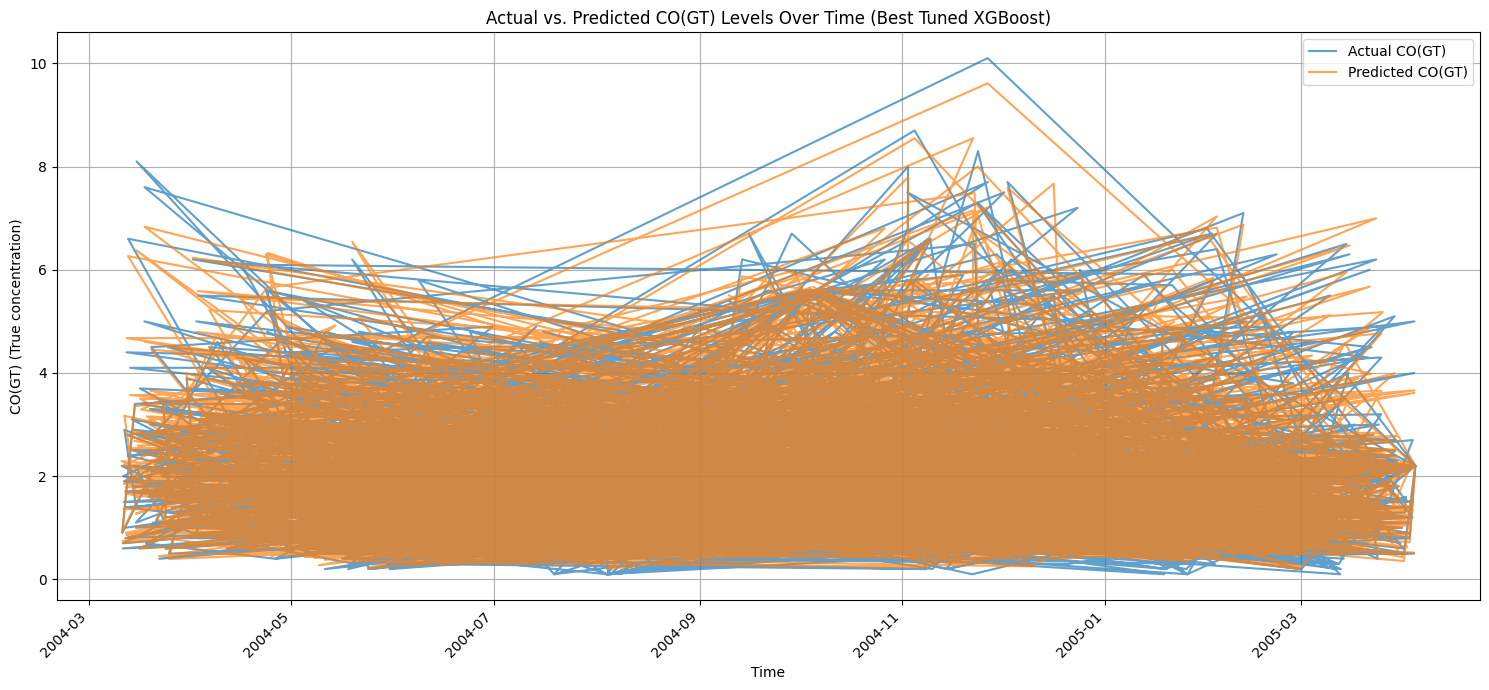

In [ ]:
# --- Visualize Errors and Predictions ---
print("\n--- Visualizing Errors and Predictions (Best Tuned XGBoost) ---")

# Redefine X and y, and train the best XGBoost model if they are not defined
output_dir = '/content/drive/MyDrive/AI'

# Load the scaled features and target variable from the previous step
try:
    X = pd.read_csv(os.path.join(output_dir, 'scaled_features.csv'), index_col='datetime', parse_dates=True)
    y_df = pd.read_csv(os.path.join(output_dir, 'target_variable.csv'), index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print("Error: Scaled feature or target variable files were not found.")
    print("Please run the previous code blocks to generate the files.")
    exit()

# Extract the Series from the DataFrame to avoid shape mismatches
y = y_df['CO(GT)']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Corrected to unpack 4 values

# Re-train the best XGBoost model (assuming best parameters found previously)
# You might want to load the best parameters from a saved file if you have one
print("\n--- Re-training Best Tuned XGBoost Model ---")
# Using the best parameters found in cell -zpC_OjzWGVc:
# {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
best_xgb = XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0, random_state=42)
best_xgb.fit(X_train, y_train)

# Make predictions with the best XGBoost model on the test set
y_pred_best_xgb = best_xgb.predict(X_test)

# Create a DataFrame for easier plotting
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best_xgb}, index=y_test.index)

# Plot actual vs. predicted values over time
plt.figure(figsize=(15, 7))
plt.plot(predictions_df.index, predictions_df['Actual'], label='Actual CO(GT)', alpha=0.7)
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted CO(GT)', alpha=0.7)
plt.title('Actual vs. Predicted CO(GT) Levels Over Time (Best Tuned XGBoost)')
plt.xlabel('Time')
plt.ylabel('CO(GT) (True concentration)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



--- Visualizing Data Split and Training Process ---

Data Split Shapes:
X_train shape: (7576, 12)
X_test shape: (1895, 12)
y_train shape: (7576,)
y_test shape: (1895,)

ANN Training History Plot:


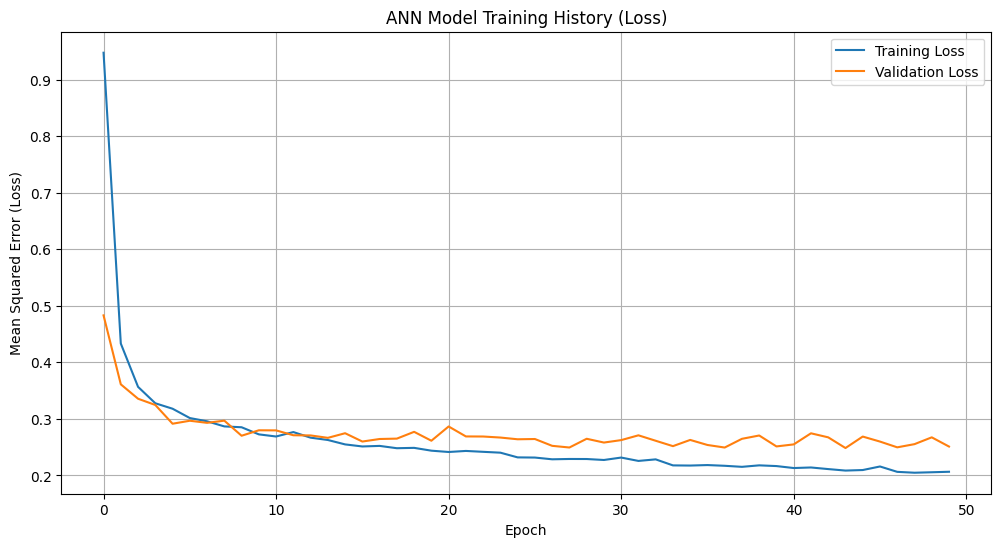

In [ ]:
# Define the path to the scaled data and target variable
output_dir = '/content/drive/MyDrive/AI'
scaled_features_path = os.path.join(output_dir, 'scaled_features.csv')
target_variable_path = os.path.join(output_dir, 'target_variable.csv')

# Load the scaled features and target variable
try:
    X = pd.read_csv(scaled_features_path, index_col='datetime', parse_dates=True)
    y_df = pd.read_csv(target_variable_path, index_col='datetime', parse_dates=True)
except FileNotFoundError:
    print("Error: Scaled feature or target variable files were not found.")
    print("Please run the previous code blocks to generate the files.")
    exit()

# Extract the Series from the DataFrame
y = y_df['CO(GT)']


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- Visualize Data Split and Training Process ---
print("\n--- Visualizing Data Split and Training Process ---")

# Display the shapes of the training and testing sets
print("\nData Split Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Plot the training history of the ANN model
# Ensure the 'history' object from the ANN training is available
if 'history' in locals():
    print("\nANN Training History Plot:")
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ANN Model Training History (Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (Loss)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nANN training history is not available. Please run the ANN training cell first.")